<a href="https://colab.research.google.com/github/sweerasingha/Facial-Key-Points-Detection/blob/main/KeyFacialPointsDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Facial Points Detection



IMPORT LIBRARIES/DATASETS AND PERFORM PRELIMINARY DATA PROCESSING

In [ ]:
# Import the necessary packages
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import optimizers

from google.colab import userdata

kaggle_username = userdata.get('kaggle_username')
kaggle_key = userdata.get('kaggle_key')


In [ ]:
import os
os.environ['KAGGLE_USERNAME']= kaggle_username
os.environ['KAGGLE_KEY']= kaggle_key

# Download dataset
! kaggle datasets download -d bhallaakshit/key-facial-points-detection

# Unzip file
! unzip /content/key-facial-points-detection.zip

# Load data on dataframe
facialpoints_df = pd.read_csv('/content/KeyFacialPoints.csv')

 99% 209M/210M [00:12<00:00, 14.4MB/s]
100% 210M/210M [00:12<00:00, 17.5MB/s]
Archive:  /content/key-facial-points-detection.zip
  inflating: KeyFacialPoints.csv     
  inflating: weights.hdf5            


In [ ]:
facialpoints_df

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2135,67.180378,35.816373,33.239956,34.921932,59.347973,37.000904,72.667896,37.097600,39.404349,36.589944,...,60.065396,64.397610,73.248393,35.446431,74.014748,48.708626,76.760852,48.559612,77.335618,191 191 191 190 189 185 184 120 54 34 19 24 31...
2136,65.724490,36.301020,25.377551,37.311224,58.530612,37.739796,74.448980,37.525510,33.551020,38.107143,...,62.472789,66.928121,79.229046,28.015377,81.151722,48.771976,81.816774,49.287271,82.871156,19 19 19 18 13 7 3 4 3 1 3 9 11 12 12 13 10 9 ...
2137,68.430866,38.651975,28.895857,37.617027,61.659350,40.100902,75.586792,40.219182,37.665118,39.087245,...,63.289576,68.864397,77.495823,22.013981,77.368995,49.180628,79.043130,47.176739,89.544522,31 40 47 31 54 58 63 100 86 80 82 75 79 86 90 ...
2138,64.152180,30.691592,27.000898,40.868082,56.505624,34.126963,73.436776,28.556335,34.746122,40.506939,...,59.735799,73.730743,70.273886,38.777143,80.684286,58.042857,79.301429,58.611086,80.355543,7 1 5 1 3 20 12 0 5 8 6 18 13 9 8 12 12 11 4 8...


In [ ]:
facialpoints_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 non-null   float

In [ ]:
# Let's take a look at a sample image
facialpoints_df['Image'][1]

'219 215 204 196 204 211 212 200 180 168 178 196 194 196 203 209 199 192 197 201 207 215 199 190 182 180 183 190 190 176 175 175 170 158 162 170 150 133 133 128 121 115 115 114 112 114 113 112 120 127 123 118 112 109 112 110 107 106 104 104 100 98 105 122 135 143 152 135 114 104 81 74 87 107 98 82 84 79 70 69 62 62 79 94 97 100 98 93 100 100 97 96 93 92 88 84 222 219 220 211 207 199 185 178 171 175 196 199 199 200 201 205 202 200 204 206 211 219 204 192 188 185 185 193 189 180 177 178 173 158 159 162 145 133 133 129 122 118 116 115 114 115 115 118 127 132 127 120 116 119 118 114 114 113 110 108 105 104 110 130 140 149 152 128 106 106 91 78 90 107 101 84 90 93 79 75 73 59 58 74 94 102 100 99 97 90 94 96 95 92 88 86 231 224 212 197 191 186 176 170 172 190 201 199 200 203 204 210 215 211 210 213 213 217 210 192 188 188 189 194 189 183 181 183 175 158 158 158 142 132 133 131 125 120 121 120 116 115 116 122 135 137 129 122 121 125 121 119 120 118 117 112 112 109 116 136 149 156 149 126 109 

In [ ]:
# Since values for the image is given as space separated string, we will need to separate the values using ' ' as separator.
# Then convert this into numpy array using np.fromstring and convert the obtained 1D array into 2D array of shape (96,96)
facialpoints_df['Image'] = facialpoints_df['Image'].apply(lambda x: np.fromstring(x, dtype= int, sep = ' ').reshape(96,96))

In [ ]:
# Let's obtain the shape of the resized image
facialpoints_df['Image'][1].shape

In [ ]:
# Let's confirm that there are no null values
facialpoints_df.isnull().sum()

In [ ]:
# Plot a random image from the dataset along with facial keypoints.
i = np.random.randint(1, len(facialpoints_df))
plt.imshow(facialpoints_df['Image'][i],cmap='gray')


In [ ]:
# The (x, y) coordinates for the 15 key features are plotted on top of the image
# Below is a for loop starting from index = 1 to 32 with step of 2
# In the first iteration j would be 1, followed by 3 and so on.
# since x-coordinates are in even columns like 0,2,4,.. and y-coordinates are in odd columns like 1,3,5,..
# we access their value using .loc command, which get the values for coordinates of the image based on the column it is refering to.
# in the first iteration df[i][j-1] would be df[i][0] refering the value in 1st column(x-coordinate) of the image in 'i' row.

plt.figure()
plt.imshow(facialpoints_df['Image'][i],cmap='gray')
for j in range(1,31,2):
        plt.plot(facialpoints_df.loc[i][j-1], facialpoints_df.loc[i][j], 'rx')


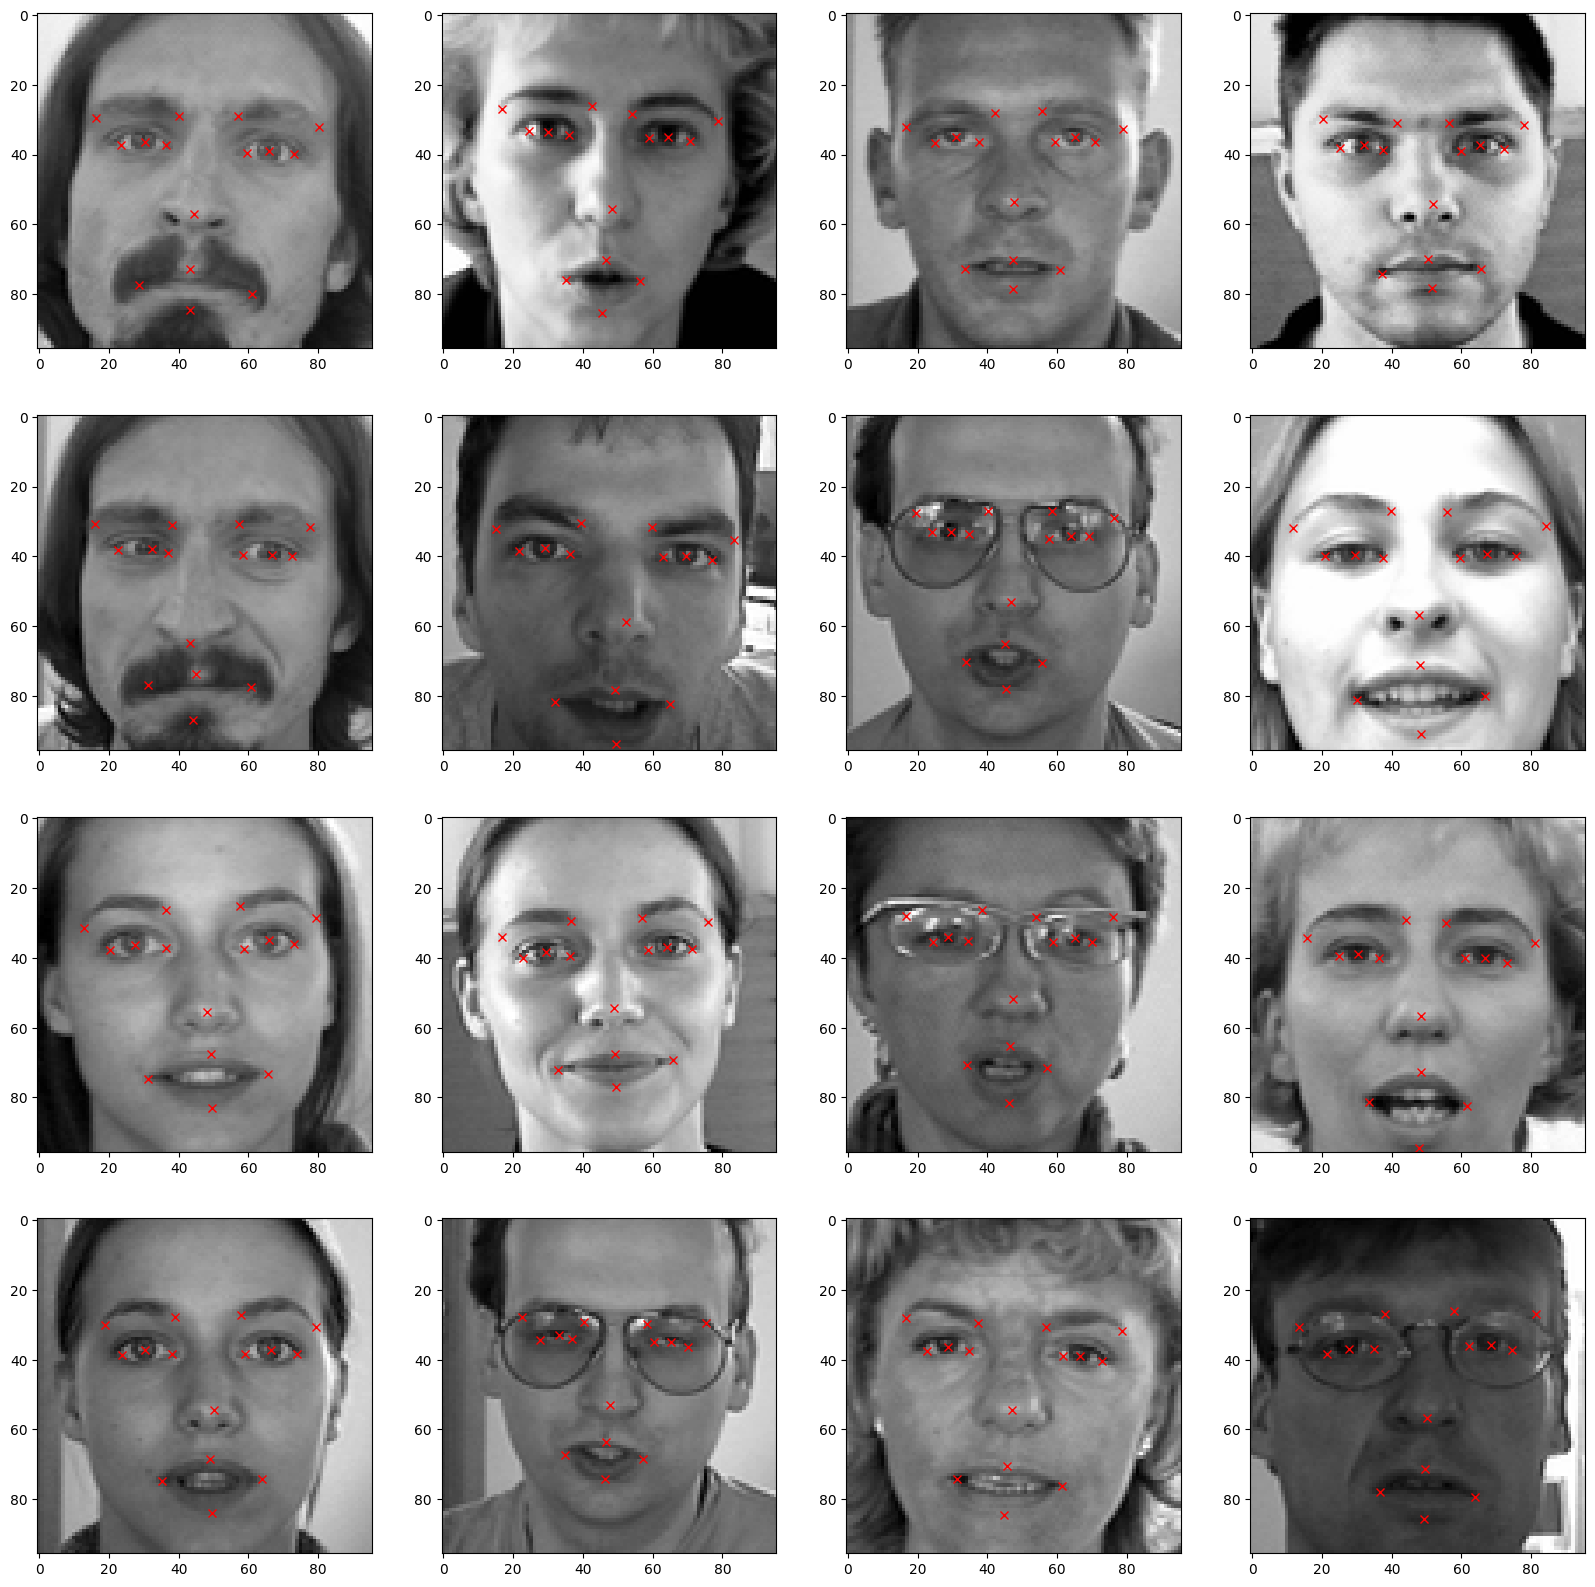

In [ ]:
# Let's view more images in a grid format
fig = plt.figure(figsize=(20, 20))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1)
    image = plt.imshow(facialpoints_df['Image'][i], cmap = 'gray')
    for j in range(1,31,2):
        plt.plot(facialpoints_df.loc[i][j-1], facialpoints_df.loc[i][j], 'rx')


Description of dataframe

In [ ]:
facialpoints_df.describe()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
count,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,...,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000
mean,66.221549,36.842274,29.640269,37.063815,59.272128,37.856014,73.412473,37.640110,36.603107,37.920852,...,47.952141,57.253926,63.419076,75.887660,32.967365,76.134065,48.081325,72.681125,48.149654,82.630412
std,2.087683,2.294027,2.051575,2.234334,2.005631,2.034500,2.701639,2.684162,1.822784,2.009505,...,3.276053,4.528635,3.650131,4.438565,3.595103,4.259514,2.723274,5.108675,3.032389,4.813557
min,47.835757,23.832996,18.922611,24.773072,41.779381,27.190098,52.947144,26.250023,24.112624,26.250023,...,24.472590,41.558400,43.869480,57.023258,9.778137,56.690208,32.260312,56.719043,33.047605,57.232296
25%,65.046300,35.468842,28.472224,35.818377,58.113054,36.607950,71.741978,36.102409,35.495730,36.766783,...,46.495330,54.466000,61.341291,72.874263,30.879288,73.280038,46.580004,69.271669,46.492000,79.417480
50%,66.129065,36.913319,29.655440,37.048085,59.327154,37.845220,73.240045,37.624207,36.620735,37.920336,...,47.900511,57.638582,63.199057,75.682465,33.034022,75.941985,47.939031,72.395978,47.980854,82.388899
75%,67.332093,38.286438,30.858673,38.333884,60.521492,39.195431,74.978684,39.308331,37.665280,39.143921,...,49.260657,60.303524,65.302398,78.774969,35.063575,78.884031,49.290000,75.840286,49.551936,85.697976
max,78.013082,46.132421,42.495172,45.980981,69.023030,47.190316,87.032252,49.653825,47.293746,44.887301,...,65.279654,75.992731,84.767123,94.673637,50.973348,93.443176,61.804506,93.916338,62.438095,95.808983


PERFORM IMAGE AUGMENTATION

In [ ]:
# Create a new copy of the dataframe
import copy
facialpoints_df_copy = copy.copy(facialpoints_df)

In [ ]:
# obtain the header of the DataFrame (names of columns)

columns = facialpoints_df_copy.columns[:-1]
columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

In [ ]:
# Take a look at the pixel values of a sample image and see if it makes sense!
facialpoints_df['Image'][0]

array([[238, 236, 237, ..., 250, 250, 250],
       [235, 238, 236, ..., 249, 250, 251],
       [237, 236, 237, ..., 251, 251, 250],
       ...,
       [186, 183, 181, ...,  52,  57,  60],
       [189, 188, 207, ...,  61,  69,  78],
       [191, 184, 184, ...,  70,  75,  90]])

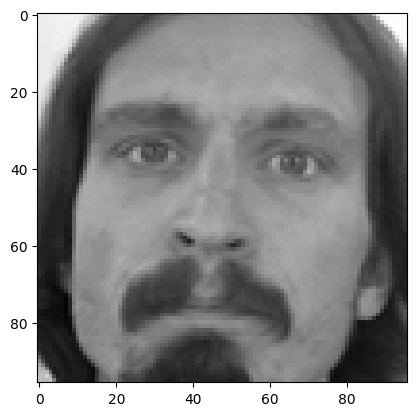

In [ ]:
# plot the sample image
plt.imshow(facialpoints_df['Image'][0], cmap = 'gray')

In [ ]:
# Now Let's flip the image column horizontally
facialpoints_df_copy['Image'] = facialpoints_df_copy['Image'].apply(lambda x: np.flip(x, axis = 1))

In [ ]:
# Now take a look at the flipped image and do a sanity check!
# Notice that the values of pixels are now flipped
facialpoints_df_copy['Image'][0]

array([[250, 250, 250, ..., 237, 236, 238],
       [251, 250, 249, ..., 236, 238, 235],
       [250, 251, 251, ..., 237, 236, 237],
       ...,
       [ 60,  57,  52, ..., 181, 183, 186],
       [ 78,  69,  61, ..., 207, 188, 189],
       [ 90,  75,  70, ..., 184, 184, 191]])

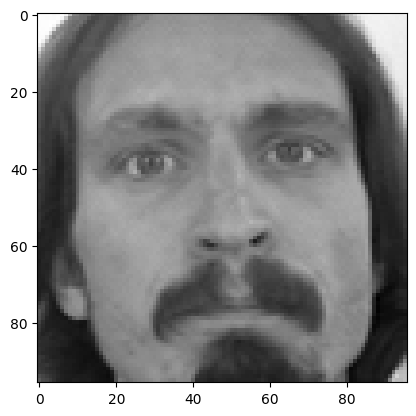

In [ ]:
# Notice that the image is flipped now
plt.imshow(facialpoints_df_copy['Image'][0], cmap = 'gray')

In [ ]:
# Since we are flipping the images horizontally, y coordinate values would be the same
# X coordinate values only would need to change, all we have to do is to subtract our initial x-coordinate values from width of the image(96)
for i in range(len(columns)):
  if i%2 == 0:
    facialpoints_df_copy[columns[i]] = facialpoints_df_copy[columns[i]].apply(lambda x: 96. - float(x) )

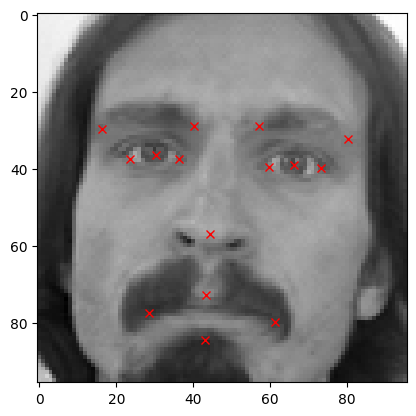

In [ ]:
# View the Original image
plt.imshow(facialpoints_df['Image'][0],cmap='gray')
for j in range(1, 31, 2):
        plt.plot(facialpoints_df.loc[0][j-1], facialpoints_df.loc[0][j], 'rx')

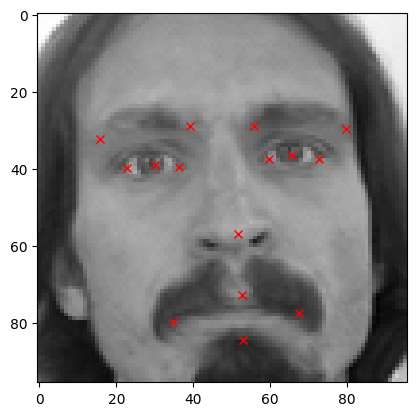

In [ ]:
# View the Horizontally flipped image
plt.imshow(facialpoints_df_copy['Image'][0], cmap='gray')
for j in range(1, 31, 2):
        plt.plot(facialpoints_df_copy.loc[0][j-1], facialpoints_df_copy.loc[0][j], 'rx')

In [ ]:
# Concatenate the original dataframe with the augmented dataframe
facialpoints_df_augmented = np.concatenate((facialpoints_df,facialpoints_df_copy))

In [ ]:
facialpoints_df_augmented.shape

(4280, 31)

In [ ]:
# Let's try to perform another image augmentation by randomly increasing images brightness
# We multiply pixel values by random values between 1 and 2 to increase the brightness of the image
# we clip the value between 0 and 255

import random

facialpoints_df_copy = copy.copy(facialpoints_df)
facialpoints_df_copy['Image'] = facialpoints_df['Image'].apply(lambda x:np.clip(random.uniform(1, 2) * x, 0.0, 255.0))
facialpoints_df_augmented = np.concatenate((facialpoints_df_augmented, facialpoints_df_copy))
facialpoints_df_augmented.shape

(6420, 31)

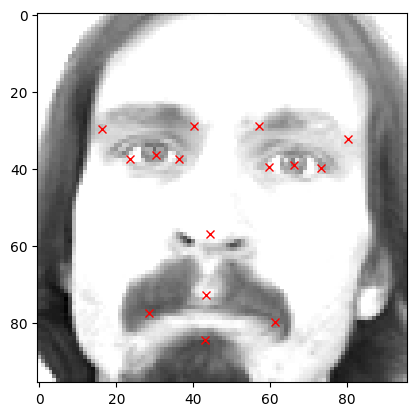

In [ ]:
# Let's view image with increased brightness

plt.imshow(facialpoints_df_copy['Image'][0], cmap = 'gray')
for j in range(1, 31, 2):
        plt.plot(facialpoints_df_copy.loc[0][j-1], facialpoints_df_copy.loc[0][j], 'rx')

Image augmentation by decreasing image brightness. A sanity check and visualize sample images

In [ ]:
# Randomly decrease image brightness
# Multiply pixel values by random values between 0 and 1 to decrease the brightness of the image
# Clip the value between 0 and 255

facialpoints_df_copy = copy.copy(facialpoints_df)
facialpoints_df_copy['Image'] = facialpoints_df['Image'].apply(lambda x:np.clip(random.uniform(0, 0.2) * x, 0.0, 255.0))
# facialpoints_df_augmented = np.concatenate((facialpoints_df_augmented, facialpoints_df_copy))
# facialpoints_df_augmented.shape

In [ ]:
facialpoints_df['Image'][0]

array([[238, 236, 237, ..., 250, 250, 250],
       [235, 238, 236, ..., 249, 250, 251],
       [237, 236, 237, ..., 251, 251, 250],
       ...,
       [186, 183, 181, ...,  52,  57,  60],
       [189, 188, 207, ...,  61,  69,  78],
       [191, 184, 184, ...,  70,  75,  90]])

In [ ]:
facialpoints_df_copy['Image'][0]

array([[11.46962491, 11.37324151, 11.42143321, ..., 12.04792533,
        12.04792533, 12.04792533],
       [11.32504981, 11.46962491, 11.37324151, ..., 11.99973362,
        12.04792533, 12.09611703],
       [11.42143321, 11.37324151, 11.42143321, ..., 12.09611703,
        12.09611703, 12.04792533],
       ...,
       [ 8.96365644,  8.81908134,  8.72269794, ...,  2.50596847,
         2.74692697,  2.89150208],
       [ 9.10823155,  9.06003985,  9.97568217, ...,  2.93969378,
         3.32522739,  3.7589527 ],
       [ 9.20461495,  8.86727304,  8.86727304, ...,  3.37341909,
         3.6143776 ,  4.33725312]])

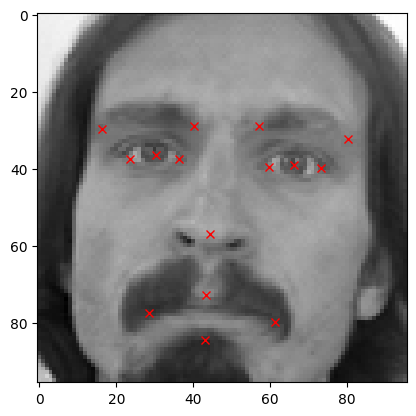

In [ ]:
# Let's view a sample image with decreased brightness decreased image
plt.imshow(facialpoints_df_copy['Image'][0], cmap = 'gray')
for j in range(1,31,2):
        plt.plot(facialpoints_df_copy.loc[0][j-1], facialpoints_df_copy.loc[0][j], 'rx')

Augment images by flipping them vertically

In [ ]:
facialpoints_df_copy = copy.copy(facialpoints_df)

In [ ]:
# Flip the image column vertically (note that axis = 0)
facialpoints_df_copy['Image'] = facialpoints_df_copy['Image'].apply(lambda x: np.flip(x, axis = 0))

In [ ]:
facialpoints_df['Image'][0]

array([[238, 236, 237, ..., 250, 250, 250],
       [235, 238, 236, ..., 249, 250, 251],
       [237, 236, 237, ..., 251, 251, 250],
       ...,
       [186, 183, 181, ...,  52,  57,  60],
       [189, 188, 207, ...,  61,  69,  78],
       [191, 184, 184, ...,  70,  75,  90]])

In [ ]:
facialpoints_df_copy['Image'][0]

array([[191, 184, 184, ...,  70,  75,  90],
       [189, 188, 207, ...,  61,  69,  78],
       [186, 183, 181, ...,  52,  57,  60],
       ...,
       [237, 236, 237, ..., 251, 251, 250],
       [235, 238, 236, ..., 249, 250, 251],
       [238, 236, 237, ..., 250, 250, 250]])

In [ ]:
# Since we are flipping the images vertically, x coordinate values would be the same
# y coordinate values only would need to change, all we have to do is to subtract our initial y-coordinate values from width of the image(96)
for i in range(len(columns)):
  if i%2 == 1:
    facialpoints_df_copy[columns[i]] = facialpoints_df_copy[columns[i]].apply(lambda x: 96. - float(x) )

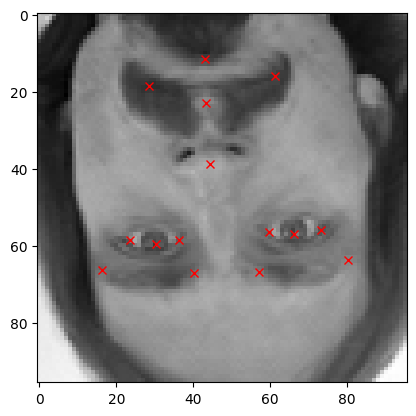

In [ ]:
# View the Horizontally flipped image
plt.imshow(facialpoints_df_copy['Image'][0], cmap='gray')
for j in range(1, 31, 2):
        plt.plot(facialpoints_df_copy.loc[0][j-1], facialpoints_df_copy.loc[0][j], 'rx')

PERFORM NORMALIZATION AND TRAINING DATA PREPARATION

In [ ]:
# Obtain the value of 'Images' and normalize it
# Note that 'Images' are in the 31st column but since indexing start from 0, we refer 31st column by 30
img = facialpoints_df_augmented[:, 30]
img = img/255.

# Create an empty array of shape (10700, 96, 96, 1) to train the model
X = np.empty((len(img), 96, 96, 1))

# Iterate through the normalized images list and add image values to the empty array
# Note that we need to expand it's dimension from (96,96) to (96,96,1)
for i in range(len(img)):
  X[i,] = np.expand_dims(img[i], axis = 2)

# Convert the array type to float32
X = np.asarray(X).astype(np.float32)
X.shape

(6420, 96, 96, 1)

In [ ]:
# Obtain the values of key face points coordinates, which are to used as target.
y = facialpoints_df_augmented[:,:30]
y = np.asarray(y).astype(np.float32)
y.shape

(6420, 30)

In [ ]:
# Split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [ ]:
X_train.shape

(5778, 96, 96, 1)

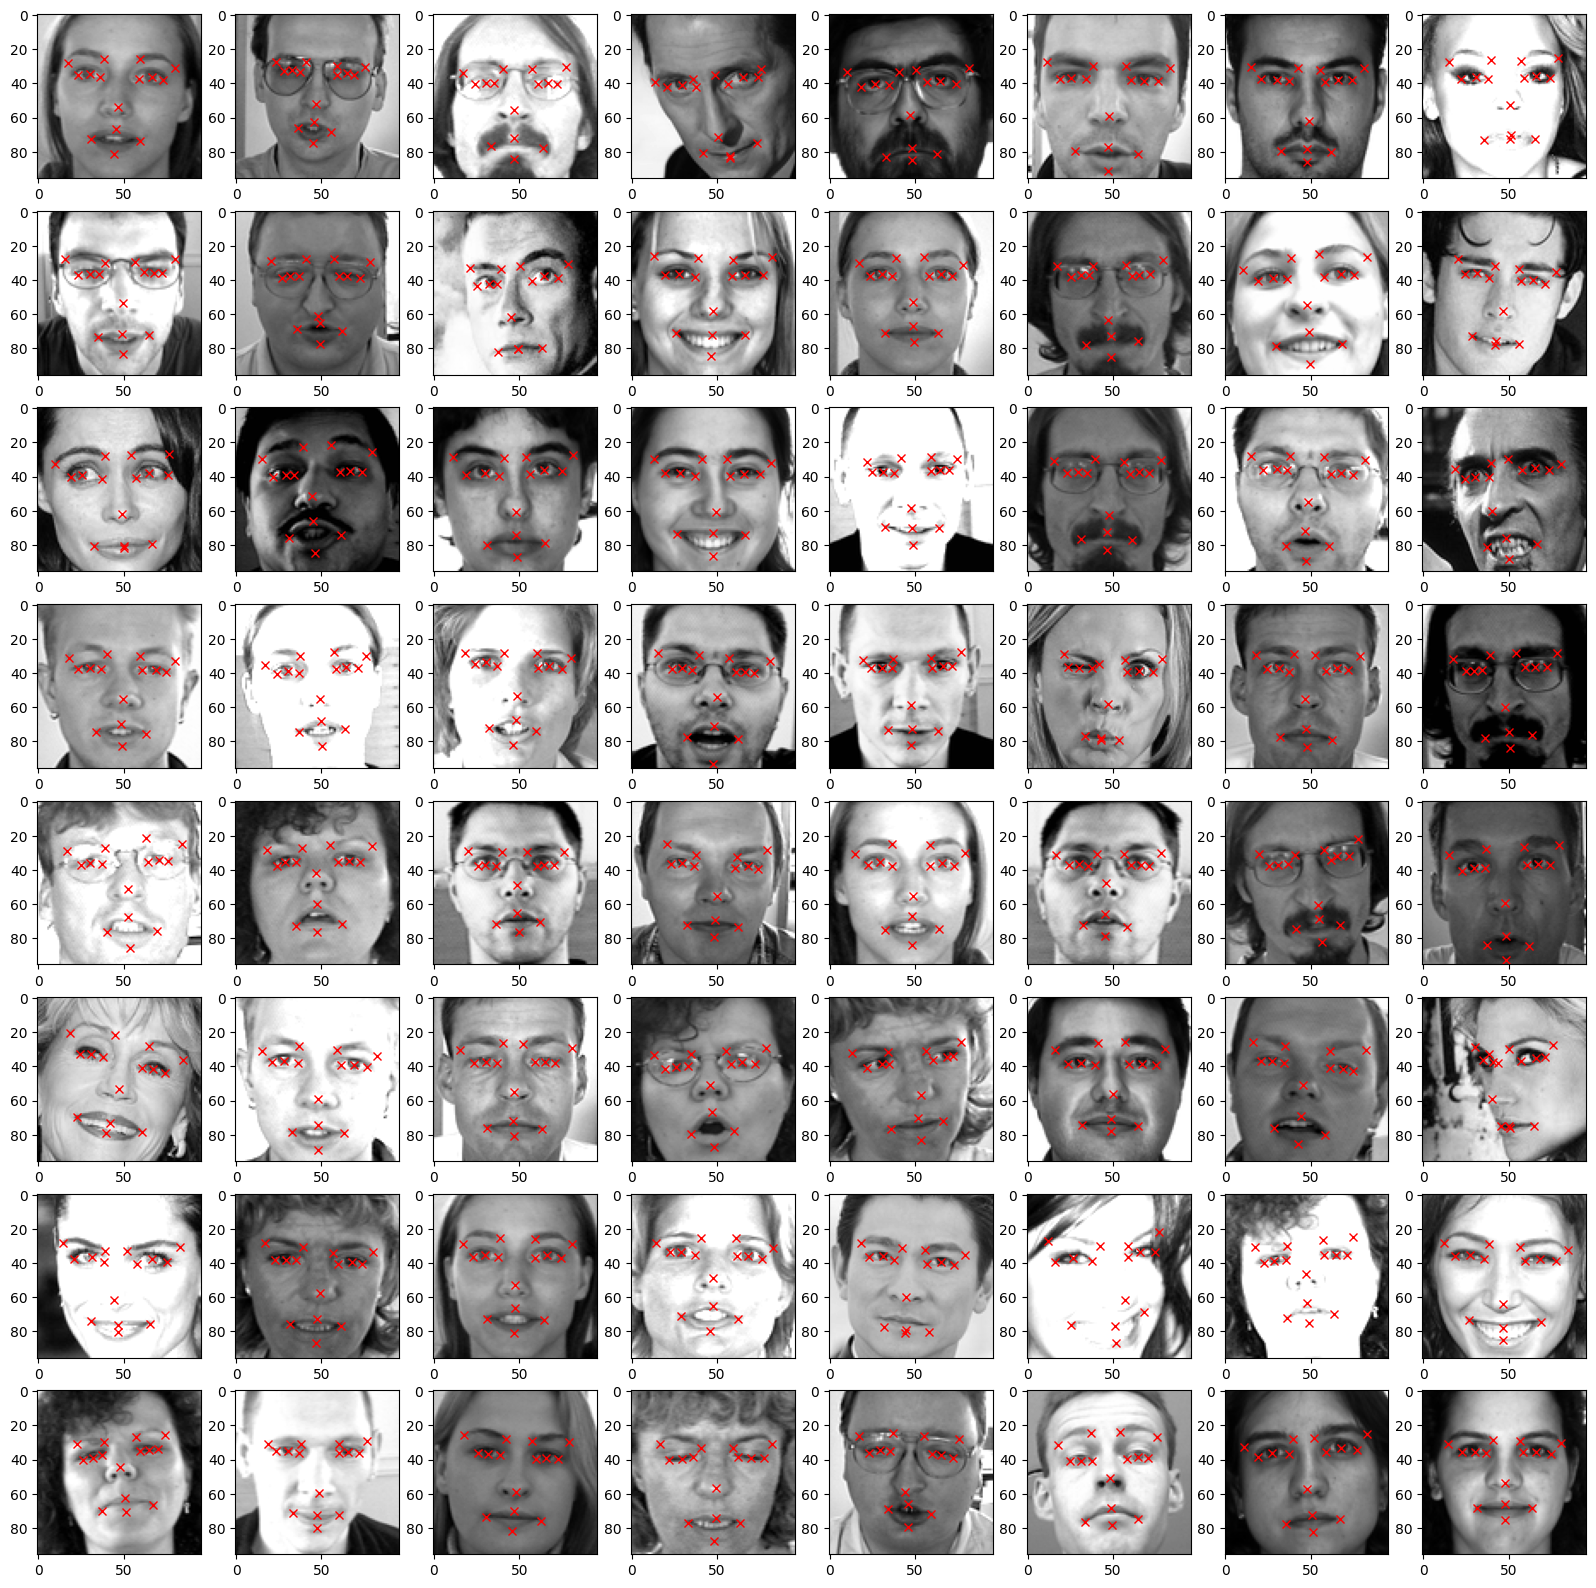

In [ ]:
# Let's view more images in a grid format
fig = plt.figure(figsize=(20, 20))

for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1)
    image = plt.imshow(X_train[i].reshape(96,96), cmap = 'gray')
    for j in range(1,31,2):
        plt.plot(y_train[i][j-1], y_train[i][j], 'rx')


BUILD DEEP RESIDUAL NEURAL NETWORK MODEL

In [ ]:
def res_block(X, filter, stage):

  # CONVOLUTIONAL BLOCK
  X_copy = X
  f1 , f2, f3 = filter

  # Main Path
  X = Conv2D(f1, (1,1), strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X)

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X)

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)

  # Short path
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # Add data from main and short paths
  X = Add()([X,X_copy])
  X = Activation('relu')(X)



  # IDENTITY BLOCK 1
  X_copy = X

  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X)

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X)

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # Add both paths together (Note that we feed the original input as is hence the name "identity")
  X = Add()([X,X_copy])
  X = Activation('relu')(X)



  # IDENTITY BLOCK 2
  X_copy = X

  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X)

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X)

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # Add both paths together (Note that we feed the original input as is hence the name "identity")
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [ ]:
input_shape = (96,96,1)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3,3))(X_input)

# Stage #1
X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# Stage #2
X = res_block(X, filter= [64,64,256], stage= 2)

# Stage #3
X = res_block(X, filter= [128,128,512], stage= 3)

# Average Pooling
X = AveragePooling2D((2,2), name = 'Averagea_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(4096, activation = 'relu')(X)
X = Dropout(0.2)(X)
X = Dense(2048, activation = 'relu')(X)
X = Dropout(0.1)(X)
X = Dense(30, activation = 'relu')(X)


model = Model( inputs= X_input, outputs = X)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 1)]          0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 102, 102, 1)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1 (Conv2D)              (None, 48, 48, 64)           3200      ['zero_padding2d[0][0]']      
                                                                                                  
 bn_conv1 (BatchNormalizati  (None, 48, 48, 64)           256       ['conv1[0][0]']           

COMPILE AND TRAIN DEEP LEARNING MODEL

In [ ]:
adam = tf.keras.optimizers.Adam(lr = 0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss="mean_squared_error", optimizer = adam, metrics = ['accuracy'])

In [ ]:
# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath = "weights.hdf5", verbose = 1, save_best_only = True)

In [ ]:
history = model.fit(X_train, y_train, batch_size = 256, epochs= 100, validation_split = 0.05, callbacks=[checkpointer])

# TASK #9: ASSESS TRAINED MODEL PERFORMANCE

In [ ]:
# Evaluate trained model

result = model.evaluate(X_test,y_test)
print("Accuracy : {}".format(result[1]))

In [ ]:
# Getting the model history keys
history.history.keys()

In [ ]:
# plot the training artifacts

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'upper right')
plt.show()

In [ ]:
# Make prediction using the testing dataset
df_predict = model.predict(X_test)

21/21 [==============================] - 1s 5ms/step


In [ ]:
# Print the rmse loss values

from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(y_test, df_predict))
print("RMSE value : {}".format(rms))

RMSE value : 6.722428419385347


In [ ]:
# Convert the predicted values into a dataframe

df_predict= pd.DataFrame(df_predict, columns = columns)
df_predict.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,30.431328,38.039806,65.076546,36.120171,36.481918,38.841152,23.954617,39.304226,58.225307,37.458305,...,46.170773,59.482525,35.735031,79.248001,62.824219,77.834518,48.397865,74.426544,48.805107,86.397377
1,65.290901,31.830496,28.489399,34.632954,57.350025,33.810028,73.336441,31.862108,36.477200,35.404644,...,48.769741,56.716137,64.979950,70.935844,33.708450,73.189865,49.526661,70.940178,49.768295,78.790070
2,38.473351,36.281803,56.075092,36.863579,40.834435,37.403214,35.295048,36.858273,51.541489,37.669933,...,38.366638,59.284111,40.173996,80.780769,56.105228,81.099838,44.997917,80.597717,45.734478,82.143311
3,65.699036,37.516525,29.515543,38.198349,57.715061,38.994576,73.949387,37.971600,36.735477,39.290707,...,44.873764,59.304478,65.220177,73.985870,30.588724,74.341537,46.878330,74.300026,46.881866,80.492279
4,65.364616,37.906219,28.077766,39.240494,58.343838,38.755695,72.363991,38.231403,34.797161,39.506382,...,46.556400,56.758350,63.251015,76.330971,33.431637,77.518143,47.903828,72.516602,48.110634,85.004990


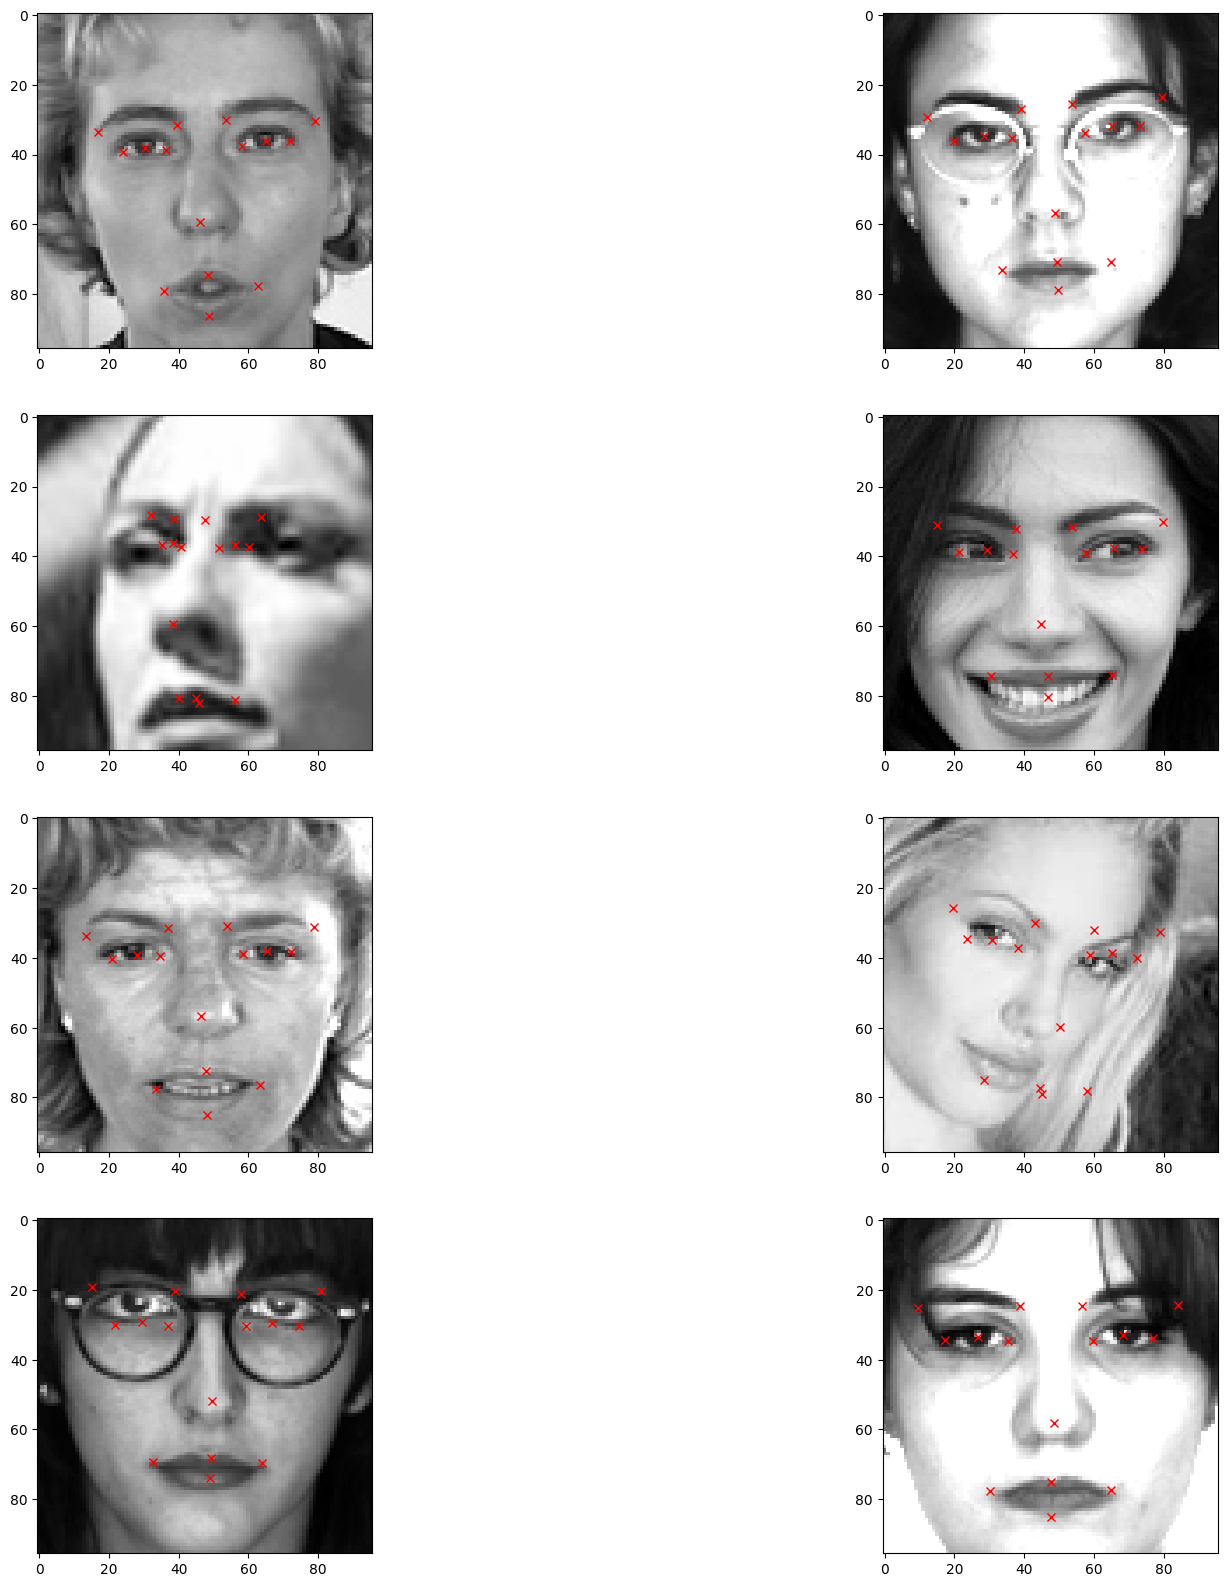

In [ ]:
# Plot the test images and their predicted keypoints

fig = plt.figure(figsize=(20, 20))

for i in range(8):
    ax = fig.add_subplot(4, 2, i + 1)
    # Using squeeze to convert the image shape from (96,96,1) to (96,96)
    plt.imshow(X_test[i].squeeze(),cmap='gray')
    for j in range(1,31,2):
            plt.plot(df_predict.loc[i][j-1], df_predict.loc[i][j], 'rx')